**DRAFT**

In [1]:
%load_ext autoreload
%autoreload 2

# Accumulated Local Effects for classifying flowers

In this example we will explain the behaviour of classification models on the Iris dataset. It is recommended to first read the [ALE regression example](ale_regression_boston.ipynb). Interpreting ALE plots for classification problems become more complex due to to reasons:

 - Instead of one ALE line for each feature we now have one for each class to explain the feature effects towards predicting each class.
 - There are multiple ways to choose the prediction function to explain:
   - Class label predictions (e.g. `clf.predict` in `sklearn`
   - Class probability predictions (e.g. `clf.predict_proba` in `sklearn`
   - Margin or logit predictions (e.g. `clf.decision_function` in `sklearn`
   
We will see the implications of explaining each of these prediction functions.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from alibi.explainers.ale import ALE, plot_ale

## Load and prepare the dataset

In [3]:
data = load_iris()
feature_names = data.feature_names
target_names = data.target_names
X = data.data
y = data.target

Shuffle the data and define the train and test set:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Fit and evaluate a logistic regression model

In [5]:
lr = LogisticRegression(penalty='none', max_iter=200)

In [6]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
accuracy_score(y_test, lr.predict(X_test))

1.0

## Calculate Accumulated Local Effects

There are several options for explaining the classifier predictions using ALE. We define three prediction functions and look at how the resulting ALE plot interpretation changes.

In [8]:
pred_fun = lr.predict
logit_fun = lr.decision_function
proba_fun = lr.predict_proba

In [9]:
pred_ale = ALE(pred_fun, feature_names=feature_names, target_names=['class'])
logit_ale = ALE(logit_fun, feature_names=feature_names, target_names=target_names)
proba_ale = ALE(proba_fun, feature_names=feature_names, target_names=target_names)

In [10]:
pred_exp = pred_ale.explain(X_train)
logit_exp = logit_ale.explain(X_train)
proba_exp = proba_ale.explain(X_train)

## ALE for the logits

We first look at the ALE plots for explaining the feature effects towards the unnormalized logit scores:

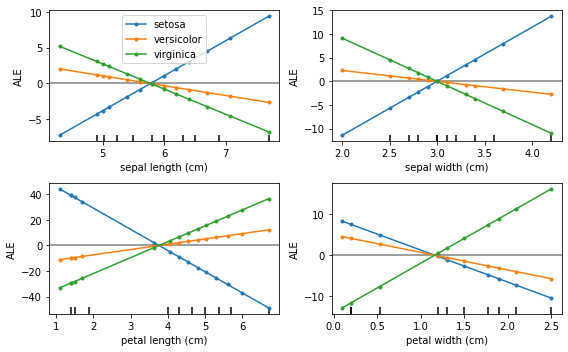

In [29]:
plot_ale(logit_exp, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5}, sharey=None);

We see that the feature effects are linear for each class and each feature. This is exactly what we should expect because the logistic regression is a linear model in the logit space.

Furthermore, the units of the ALE plots here are in logits which means that the feature effect at some feature value will be a positive or negative contribution to the logit of each class with respect to the mean prediction.

Let's look at the interpretation of the feature effects for "petal length" in more detail:

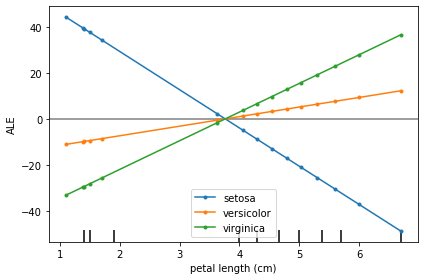

In [152]:
plot_ale(logit_exp, features=[2]);

The ALE lines cross the 0 mark at ~4cm which means that for instances of petal length around ~4cm the model is no wiser than to predict the mean response over the training set. On the other hand, going towards the extreme values of the feature, the model assigns a large positive/negative penalty towards classifying instances as "setosa" and vice versa for the other two classes.

We can go into a bit more detail about the "mean response" at the petal length around ~4cm. First, we calculate the mean response (in logit space) of the model on the training set:

In [166]:
logit_fun(X_train).mean(axis=0)

array([-7.14467361, 12.22713087, -5.08245726])

Next, we find instances for which the feature "petal length" is close to ~4cm and look at the predictions for these:

In [158]:
subset = X_train[(X_train[:, 2] > 3.8) & (X_train[:, 2] < 4.2)]
print(subset.shape)

(9, 4)


In [159]:
subset

array([[5.8, 2.7, 4.1, 1. ],
       [6. , 2.2, 4. , 1. ],
       [5.5, 2.3, 4. , 1.3],
       [5.5, 2.5, 4. , 1.3],
       [5.2, 2.7, 3.9, 1.4],
       [5.6, 3. , 4.1, 1.3],
       [5.7, 2.8, 4.1, 1.3],
       [6.1, 2.8, 4. , 1.3],
       [5.8, 2.6, 4. , 1.2]])

In [160]:
logit_fun(subset).mean(axis=0)

array([-16.34164278,  14.1959149 ,   2.14572788])

We can gain more insight into the ALE plot by looking at the class histograms for this feature:

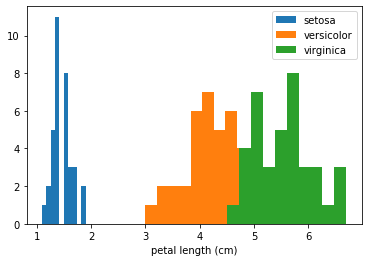

In [70]:
fig, ax = plt.subplots()
for target in range(3):
    ax.hist(X_train[y_train==target][:,2], label=target_names[target]);

ax.set_xlabel(feature_names[2])
ax.legend();

Here we see that the three classes are very well separated by this feature. This confirms that the ALE plot is behaving as expected—the feature effects of small value of "petal length" are that of increasing the the logit values for the class "setosa" and decreasing for the other two classes. Also note that the range of the ALE values for this feature is particularly high compared to other features which can be interpreted as the model attributing more importance to this feature as it separates the classes well on its own.

In [79]:
subset = X_train[(X_train[:,2]>3.9) & (X_train[:,2]<4.1)]

In [80]:
subset

array([[6. , 2.2, 4. , 1. ],
       [5.5, 2.3, 4. , 1.3],
       [5.5, 2.5, 4. , 1.3],
       [6.1, 2.8, 4. , 1.3],
       [5.8, 2.6, 4. , 1.2]])

In [81]:
logit_fun(subset)

array([[-17.45385077,  15.64738433,   1.80646644],
       [-21.1025304 ,  14.81755032,   6.28498008],
       [-18.81496293,  14.35785757,   4.45710535],
       [-12.4531494 ,  12.84389577,  -0.39074637],
       [-15.42247755,  14.14480204,   1.27767552]])

In [86]:
reduced_lr = LogisticRegression(penalty='none')
reduced_lr.fit(X_train[:, 2].reshape(-1, 1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
red_logit_ale = ALE(reduced_lr.decision_function, feature_names=[feature_names[2]],
                    target_names=target_names)

In [93]:
red_exp = red_logit_ale.explain(X_train[:, 2].reshape(-1, 1))

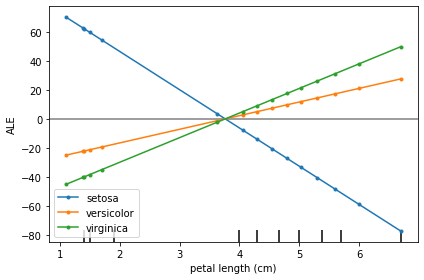

In [95]:
plot_ale(red_exp);

In [101]:
np.bincount(y_train)

array([35, 39, 38])

In [99]:
reduced_lr.decision_function(X_train[:, 2].reshape(-1, 1)).mean(axis=0)

array([-30.63750711,  19.30642199,  11.33108512])

In [100]:
reduced_lr.decision_function(subset[:, 2].reshape(-1, 1))

array([[-35.71381859,  21.11622863,  14.59758995],
       [-35.71381859,  21.11622863,  14.59758995],
       [-35.71381859,  21.11622863,  14.59758995],
       [-35.71381859,  21.11622863,  14.59758995],
       [-35.71381859,  21.11622863,  14.59758995]])

## ALE for the probabilities

We now turn to interprting the ALE plots for explaining the feature effects on the probabilities of each class.

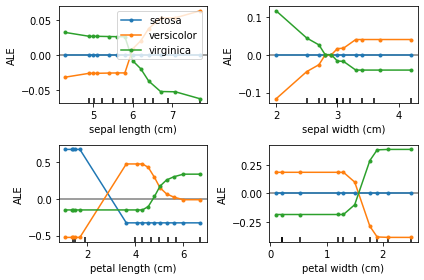

In [108]:
plot_ale(proba_exp, n_cols=2);

Note that in this case the ALE are in the units of relative probability mass, i.e. given a feature value how much more (less) probability does the model assign to each class relative to the mean prediction.

As expected, the ALE plots are no longer linear which reflects the non-linear nature of applying the softmax transformation to the linear logit scores.

## ALE for the class predictions

THIS SHOULD NOT BE USED

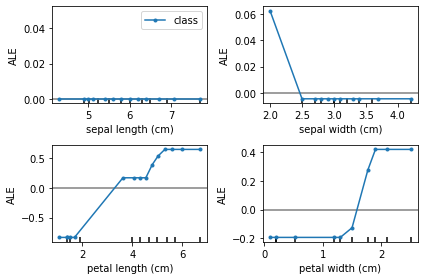

In [109]:
plot_ale(pred_exp, n_cols=2);

In [119]:
lr.predict(X_train).mean()

1.0267857142857142

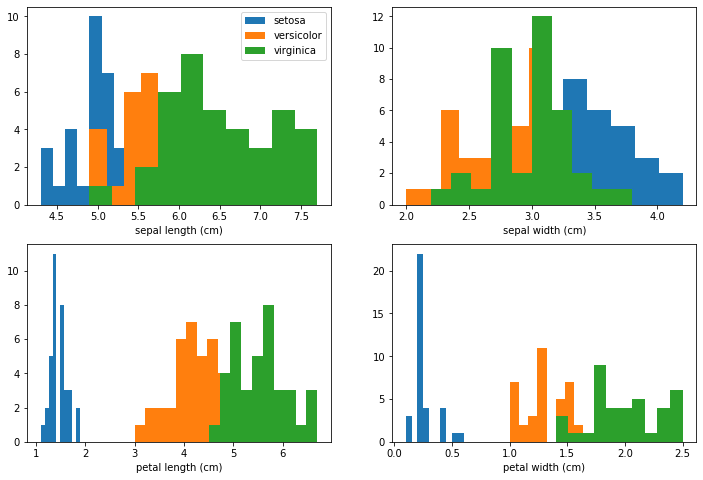

In [117]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax_ravel = ax.ravel()

for feature in range(4):
    for target in range(3):
        ax_ravel[feature].hist(X_train[y_train==target][:,feature], label=target_names[target]);
    ax_ravel[feature].set_xlabel(feature_names[feature])

ax_ravel[0].legend();

## ALE for gradient boosting

Finally, we look at the resulting ALE plots for a highly non-linear model—a gradient boosted classifier.

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

In [130]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [135]:
accuracy_score(y_test, gb.predict(X_test))

1.0

As before, we explain the feature contributions in both margin and probability space.

In [136]:
pred_fun = gb.predict
logit_fun = gb.decision_function
proba_fun = gb.predict_proba

In [137]:
pred_ale = ALE(pred_fun, feature_names=feature_names, target_names=['class'])
logit_ale = ALE(logit_fun, feature_names=feature_names, target_names=target_names)
proba_ale = ALE(proba_fun, feature_names=feature_names, target_names=target_names)

In [138]:
pred_exp = pred_ale.explain(X_train)
logit_exp = logit_ale.explain(X_train)
proba_exp = proba_ale.explain(X_train)

### ALE in margin space

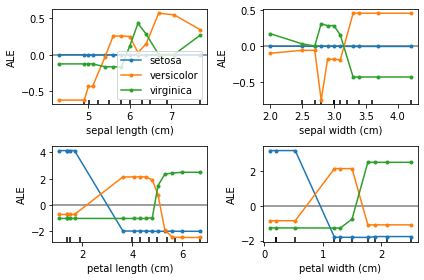

In [139]:
plot_ale(logit_exp, n_cols=2);

### ALE in probability space

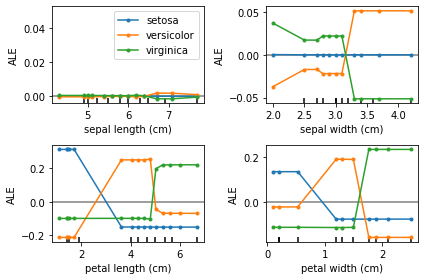

In [140]:
plot_ale(proba_exp, n_cols=2);

### ALE in class space

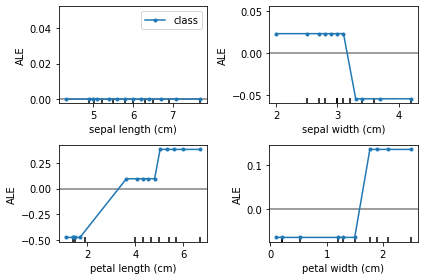

In [141]:
plot_ale(pred_exp, n_cols=2);